# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub>.

### TODO:
* Calculate properly the column kernels for O<sub>3</sub> and SO<sub>2</sub>.

## Imports and supporting functions

In [1]:
import os
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson

In [2]:
%run functions_general.ipynb
%run functions_cams.ipynb
%run functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

### Notes:

* eccodes must be installed to be able to read grib files (Linux)
    * Reference: https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a

* cartopy needs the following:
    * sudo apt-get install libproj-dev proj-data proj-bin 
    * sudo apt-get install libgeos-dev 
    * sudo pip install cython

## 1. Define datasets

In [4]:
model = 'cams'
sensor = 'tropomi'
component_nom = 'O3'

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

  Nomenclature  Weight Component TROPOMI_product               TROPOMI_column
2           O3    48.0     ozone      L2__O3____  ozone_total_vertical_column


In [5]:
# Define latitudes and longitudes
lat_min = 48.5
lat_max = 51.1
lon_min = 12
lon_max = 18.9

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

In [6]:
# Define period
period = ('2021-07-21T00:00:00Z', '2021-07-21T23:00:00Z')
start_date = period[0].split('T')[0]
end_date = period[1].split('T')[0]

## 2. Sensor data

### Collect and read data as xarray

In [7]:
# Used for testing (Change period above)
#file_name = 'd762cc7a-f037-4fb8-bc04-cac8e7f39f5b'
#product_name = 'S5P_NRTI_L2__NO2____20210621T124026_20210621T124526_19112_01_010400_20210621T132518.nc'

# Download file
input_type = 'Query'
processing_mode = 'Near real time' # Offline, Near real time, Reprocessing
file_name, product_name = TROPOMI_download(input_type, bbox, period, product_type, processing_mode)

# Read file
sensor_ds, support_input_ds, support_details_ds = TROPOMI_read(product_name, component_nom)
sensor_ds

You can see all the results at https://s5phub.copernicus.eu/dhus/.
RESULTS
Number 0: S5P_NRTI_L2__O3_____20210721T113737_20210721T114237_19537_02_020201_20210721T124125
SELECTED
File name: fa651e51-d391-4c89-9002-0b1ecab1a8ec
Product name: S5P_NRTI_L2__O3_____20210721T113737_20210721T114237_19537_02_020201_20210721T124125.nc
The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 450, layer: 13, level: 14, scanline: 357, time: 1)
Coordinates:
  * scanline                               (scanline) float64 0.0 1.0 ... 356.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * time                                   (time) datetime64[ns] 2021-07-21
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...

In [8]:
support_details_ds

<xarray.Dataset>
Dimensions:                                 (ground_pixel: 450, layer: 13, level: 14, number_of_doas_polynomial_coefficients: 4, number_of_slant_columns: 4, scanline: 357, time: 1)
Coordinates:
  * number_of_slant_columns                 (number_of_slant_columns) int32 0...
  * number_of_doas_polynomial_coefficients  (number_of_doas_polynomial_coefficients) int32 ...
Dimensions without coordinates: ground_pixel, layer, level, scanline, time
Data variables: (12/25)
    ozone_profile_apriori                   (time, scanline, ground_pixel, layer) float32 ...
    averaging_kernel                        (time, scanline, ground_pixel, layer) float32 ...
    pressure_grid                           (time, scanline, ground_pixel, level) float32 ...
    fitted_slant_columns                    (time, scanline, ground_pixel, number_of_slant_columns) float64 ...
    fitted_slant_columns_precision          (time, scanline, ground_pixel, number_of_slant_columns) float32 ...
    number_of_iterations_slant_column       (time, scanline, ground_pixel) float32 ...
    ...                                      ...
    number_of_iterations_vertical_column    (time, scanline, ground_pixel) float32 ...
    effective_scene_albedo                  (time, scanline, ground_pixel) float32 ...
    effective_scene_albedo_precision        (time, scanline, ground_pixel) float32 ...
    doas_polynomial_coefficients            (time, scanline, ground_pixel, number_of_doas_polynomial_coefficients) float32 ...
    euv                                     (time, scanline, ground_pixel) float32 ...
    processing_quality_flags                (time, scanline, ground_pixel) float64 ...

In [9]:
support_input_ds

<xarray.Dataset>
Dimensions:                              (ground_pixel: 450, scanline: 357, time: 1)
Dimensions without coordinates: ground_pixel, scanline, time
Data variables: (12/32)
    surface_altitude                     (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision           (time, scanline, ground_pixel) float32 ...
    surface_classification               (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier  (time, scanline) float64 ...
    instrument_configuration_version     (time, scanline) float32 ...
    scaled_small_pixel_variance          (time, scanline, ground_pixel) float32 ...
    ...                                   ...
    surface_albedo                       (time, scanline, ground_pixel) float32 ...
    effective_scene_height               (time, scanline, ground_pixel) float32 ...
    effective_scene_height_precision     (time, scanline, ground_pixel) float32 ...
    effective_scene_pressure             (time, scanline, ground_pixel) float32 ...
    effective_scene_pressure_precision   (time, scanline, ground_pixel) float32 ...
    cloud_fraction_apriori               (time, scanline, ground_pixel) float32 ...

### Calculate level pressures

In [10]:
sensor_ds = TROPOMI_pressure(sensor_ds, component_nom, support_input_ds, support_details_ds)
sensor_ds

The layers pressures will be retrieved.


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 450, layer: 13, level: 14, scanline: 357, time: 1)
Coordinates:
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
  * scanline                               (scanline) float64 0.0 1.0 ... 356.0
  * time                                   (time) datetime64[ns] 2021-07-21
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object nan ... nan
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...
    pressure                               (time, scanline, ground_pixel, level) float32 ...

### Calculate column kernels

In [11]:
sensor_ds = TROPOMI_kernel_column(sensor_ds, support_details_ds)
sensor_ds

The dataset does not contain information to retrieve or calculate the column averaging kernels.


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 450, layer: 13, level: 14, scanline: 357, time: 1)
Coordinates:
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
  * scanline                               (scanline) float64 0.0 1.0 ... 356.0
  * time                                   (time) datetime64[ns] 2021-07-21
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object nan ... nan
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...
    pressure                               (time, scanline, ground_pixel, level) float32 ...

### Retrieve apriori profiles

In [12]:
sensor_ds = TROPOMI_profile_apriori(sensor_ds, component, support_details_ds)
sensor_ds

<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 450, layer: 13, level: 14, scanline: 357, time: 1)
Coordinates:
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
  * scanline                               (scanline) float64 0.0 1.0 ... 356.0
  * time                                   (time) datetime64[ns] 2021-07-21
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object nan ... nan
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...
    pressure                               (time, scanline, ground_pixel, level) float32 ...
    profile_apriori                        (time, scanline, ground_pixel, layer) float32 ...

### Subset data

In [13]:
sensor_ds = TROPOMI_subset(sensor_ds, product_name, bbox)
sensor_ds

<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 144, layer: 13, level: 14, scanline: 76, time: 1)
Coordinates:
  * ground_pixel                           (ground_pixel) float64 127.0 ... 2...
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
  * scanline                               (scanline) float64 157.0 ... 232.0
  * time                                   (time) datetime64[ns] 2021-07-21
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object nan ... nan
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...
    pressure                               (time, scanline, ground_pixel, level) float32 ...
    profile_apriori                        (time, scanline, ground_pixel, layer) float32 ...

In [14]:
sensor_coords_df = TROPOMI_subset_coords(sensor_ds)
sensor_coords_df

ground_pixel  scanline   latitude  longitude
0             127.0     157.0  47.145008  12.773775
1             127.0     158.0  47.192673  12.749171
2             127.0     159.0  47.240307  12.724477
3             127.0     160.0  47.287945  12.699731
4             127.0     161.0  47.335583  12.674969
...             ...       ...        ...        ...
10939         270.0     228.0  52.126972  18.402065
10940         270.0     229.0  52.175411  18.381382
10941         270.0     230.0  52.223850  18.360634
10942         270.0     231.0  52.272289  18.339811
10943         270.0     232.0  52.320759  18.319046

[10944 rows x 4 columns]

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [15]:
sensor_ds = TROPOMI_convert_units(sensor_ds, sensor_column)
sensor_ds

The units of the component columns have been converted to molecules/cm2.
The units of the apriori profiles have been converted to molecules/cm2.


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 144, layer: 13, level: 14, scanline: 76, time: 1)
Coordinates:
  * ground_pixel                           (ground_pixel) float64 127.0 ... 2...
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
  * scanline                               (scanline) float64 157.0 ... 232.0
  * time                                   (time) datetime64[ns] 2021-07-21
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object nan ... nan
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float64 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...
    pressure                               (time, scanline, ground_pixel, level) float32 ...
    profile_apriori                        (time, scanline, ground_pixel, layer) float64 ...

## 3. Model data

### Collect and read data as xarray

In [16]:
CAMS_download(start_date, end_date, component, component_nom)
model_ds = CAMS_read(start_date, end_date, component, component_nom)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 4)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-13T17:53 GRIB to CDM+CF via cfgrib-0.9.9...

In [17]:
model_ds = CAMS_subset(model_ds, bbox)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4)
Coordinates:
    time        datetime64[ns] 2021-07-21
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] 2021-07-21 ... 2021-07-21T18:00:00
Data variables:
    component   (step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-13T17:53 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [18]:
model_levels = CAMS_137_levels()
model_levels

a [Pa]         b   ph [hPa]   pf [hPa]  Geopotential Altitude [m]  \
hybrid                                                                         
1        2.000365  0.000000     0.0200     0.0100                   79301.79   
2        3.102241  0.000000     0.0310     0.0255                   73721.58   
3        4.666084  0.000000     0.0467     0.0388                   71115.75   
4        6.827977  0.000000     0.0683     0.0575                   68618.43   
5        9.746966  0.000000     0.0975     0.0829                   66210.99   
...           ...       ...        ...        ...                        ...   
133     62.781250  0.988500  1002.2250  1000.5165                     106.54   
134     22.835938  0.991984  1005.3562  1003.7906                      79.04   
135      3.757813  0.995003  1008.2239  1006.7900                      53.92   
136      0.000000  0.997630  1010.8487  1009.5363                      30.96   
137      0.000000  1.000000  1013.2500  1012.0494                      10.00   

       Geometric Altitude [m] Temperature [K]  Density [kg/m^3]    ph [Pa]  \
hybrid                                                                       
1                    80301.65          198.05          0.000018       2.00   
2                    74584.91          209.21          0.000042       3.10   
3                    71918.79          214.42          0.000063       4.67   
4                    69365.77          221.32          0.000090       6.83   
5                    66906.53          228.06          0.000127       9.75   
...                       ...             ...               ...        ...   
133                    106.54          287.46          1.212498  100222.50   
134                     79.04          287.64          1.215710  100535.62   
135                     53.92          287.80          1.218650  100822.39   
136                     30.96          287.95          1.221341  101084.87   
137                     10.00          288.09          1.223803  101325.00   

        ph-diff [Pa]  Depth [m]  
hybrid                           
1               2.00    5580.21  
2               1.10    2605.83  
3               1.57    2497.32  
4               2.16    2407.44  
5               2.92    2320.96  
...              ...        ...  
133           341.69      27.50  
134           313.12      25.12  
135           286.77      22.96  
136           262.48      20.96  
137           240.13      10.00  

[137 rows x 11 columns]

### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [19]:
conversion_method = 'Simple'
model_ds = CAMS_kg_kg_to_kg_m2(model_ds, model_levels, conversion_method)
model_ds = CAMS_kg_m2_to_molecules_cm2(model_ds, component_mol_weight)

## 4. Apply averaging kernels

In [20]:
match_df = sensor_ds.to_dataframe()
match_df

latitude  longitude  \
corner ground_pixel       scanline                                    
0.0    127.0        0  0  157.0    2021-07-21  47.145008  12.773775   
                          158.0    2021-07-21  47.192673  12.749171   
                          159.0    2021-07-21  47.240307  12.724477   
                          160.0    2021-07-21  47.287945  12.699731   
                          161.0    2021-07-21  47.335583  12.674969   
...                                                  ...        ...   
3.0    270.0        12 13 228.0    2021-07-21  52.126972  18.402065   
                          229.0    2021-07-21  52.175411  18.381382   
                          230.0    2021-07-21  52.223850  18.360634   
                          231.0    2021-07-21  52.272289  18.339811   
                          232.0    2021-07-21  52.320759  18.319046   

                                                           delta_time  \
corner ground_pixel       scanline                                      
0.0    127.0        0  0  157.0    2021-07-21 2021-07-21 11:39:49.010   
                          158.0    2021-07-21 2021-07-21 11:39:49.850   
                          159.0    2021-07-21 2021-07-21 11:39:50.690   
                          160.0    2021-07-21 2021-07-21 11:39:51.530   
                          161.0    2021-07-21 2021-07-21 11:39:52.370   
...                                                               ...   
3.0    270.0        12 13 228.0    2021-07-21 2021-07-21 11:40:48.649   
                          229.0    2021-07-21 2021-07-21 11:40:49.489   
                          230.0    2021-07-21 2021-07-21 11:40:50.329   
                          231.0    2021-07-21 2021-07-21 11:40:51.169   
                          232.0    2021-07-21 2021-07-21 11:40:52.009   

                                              time_utc  qa_value  \
corner ground_pixel       scanline                                 
0.0    127.0        0  0  157.0    2021-07-21      NaN       1.0   
                          158.0    2021-07-21      NaN       0.9   
                          159.0    2021-07-21      NaN       1.0   
                          160.0    2021-07-21      NaN       1.0   
                          161.0    2021-07-21      NaN       1.0   
...                                                ...       ...   
3.0    270.0        12 13 228.0    2021-07-21      NaN       0.9   
                          229.0    2021-07-21      NaN       1.0   
                          230.0    2021-07-21      NaN       1.0   
                          231.0    2021-07-21      NaN       1.0   
                          232.0    2021-07-21      NaN       1.0   

                                               ozone_total_vertical_column  \
corner ground_pixel       scanline                                           
0.0    127.0        0  0  157.0    2021-07-21                 8.276267e+18   
                          158.0    2021-07-21                 8.192138e+18   
                          159.0    2021-07-21                 8.120272e+18   
                          160.0    2021-07-21                 8.193578e+18   
                          161.0    2021-07-21                 8.152051e+18   
...                                                                    ...   
3.0    270.0        12 13 228.0    2021-07-21                 8.696312e+18   
                          229.0    2021-07-21                 8.670343e+18   
                          230.0    2021-07-21                 8.652193e+18   
                          231.0    2021-07-21                 8.648608e+18   
                          232.0    2021-07-21                 8.674520e+18   

                                               ozone_total_vertical_column_precision  \
corner ground_pixel       scanline                                                     
0.0    127.0        0  0  157.0    2021-07-21                               0.002255   
          

In [21]:
if 'kernel_column' in list(sensor_ds.keys()):
    
    print('This dataset contains data to apply the column averaging kernels.')
    kernels_method = 'Nearest neighbours'
    match_df = TROPOMI_apply_avg_kernels(kernels_method, match_df)
    
else:
    
    print('This dataset does not contain data to apply the averaging kernels.')
    print('The partial columns will be sumed up.')
    print('The sum will be matched to the sensor data by nearest neighbours.')

    model_ds = model_ds.component.sum(dim = 'hybrid', skipna = False)
    model_times = model_ds.valid_time.data

    if component_nom == 'O3':
        match_df.index.names = ['corner', 'ground_pixel', 'layer', 'level', 'scanline', 'time']
        match_df = match_df.reset_index(level = ['level'])

    match_df = match_df.reset_index(level = ['layer'])
    match_df = match_df.droplevel(['corner']).drop_duplicates()

    match_df['step_index'] = match_df.apply(lambda row: nearest_neighbour(model_times, row['delta_time']), axis = 1)
    match_df['model_time'] = match_df.apply(lambda row: model_ds.valid_time[row['step_index']].values, axis = 1)
    match_df['model_column'] = match_df.apply(lambda row: model_ds.sel(latitude = row['latitude'], 
                                                                       longitude = row['longitude'],
                                                                       method = 'nearest').isel(step = int(row['step_index'])).values, 
                                                                       axis = 1)

match_df

This dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.


layer  level   latitude  longitude  \
ground_pixel scanline time                                             
127.0        157.0    2021-07-21      0      0  47.145008  12.773775   
             158.0    2021-07-21      0      0  47.192673  12.749171   
             159.0    2021-07-21      0      0  47.240307  12.724477   
             160.0    2021-07-21      0      0  47.287945  12.699731   
             161.0    2021-07-21      0      0  47.335583  12.674969   
...                                 ...    ...        ...        ...   
270.0        228.0    2021-07-21     12     13  52.126972  18.402065   
             229.0    2021-07-21     12     13  52.175411  18.381382   
             230.0    2021-07-21     12     13  52.223850  18.360634   
             231.0    2021-07-21     12     13  52.272289  18.339811   
             232.0    2021-07-21     12     13  52.320759  18.319046   

                                              delta_time time_utc  qa_value  \
ground_pixel scanline time                                                    
127.0        157.0    2021-07-21 2021-07-21 11:39:49.010      NaN       1.0   
             158.0    2021-07-21 2021-07-21 11:39:49.850      NaN       0.9   
             159.0    2021-07-21 2021-07-21 11:39:50.690      NaN       1.0   
             160.0    2021-07-21 2021-07-21 11:39:51.530      NaN       1.0   
             161.0    2021-07-21 2021-07-21 11:39:52.370      NaN       1.0   
...                                                  ...      ...       ...   
270.0        228.0    2021-07-21 2021-07-21 11:40:48.649      NaN       0.9   
             229.0    2021-07-21 2021-07-21 11:40:49.489      NaN       1.0   
             230.0    2021-07-21 2021-07-21 11:40:50.329      NaN       1.0   
             231.0    2021-07-21 2021-07-21 11:40:51.169      NaN       1.0   
             232.0    2021-07-21 2021-07-21 11:40:52.009      NaN       1.0   

                                  ozone_total_vertical_column  \
ground_pixel scanline time                                      
127.0        157.0    2021-07-21                 8.276267e+18   
             158.0    2021-07-21                 8.192138e+18   
             159.0    2021-07-21                 8.120272e+18   
             160.0    2021-07-21                 8.193578e+18   
             161.0    2021-07-21                 8.152051e+18   
...                                                       ...   
270.0        228.0    2021-07-21                 8.696312e+18   
             229.0    2021-07-21                 8.670343e+18   
             230.0    2021-07-21                 8.652193e+18   
             231.0    2021-07-21                 8.648608e+18   
             232.0    2021-07-21                 8.674520e+18   

                                  ozone_total_vertical_column_precision  \
ground_pixel scanline time                                                
127.0        157.0    2021-07-21                               0.002255   
             158.0    2021-07-21                               0.002140   
             159.0    2021-07-21                               0.002036   
             160.0    2021-07-21                               0.002729   
             161.0    2021-07-21                               0.002749   
...                                                                 ...   
270.0        228.0    2021-07-21                               0.001812   
             229.0    2021-07-21                               0.002822   
             230.0    2021-07-21                               0.001932   
             231.0    2021-07-21                               0.001701   
             232.0    2021-07-21                               0.001899   

                                      pressure  profile_apriori  step_index  \
ground_pixel scanline time                                                    
127.0        157.0    2021-07-21  79269.828125     2.994366e+17           2   
          

In [22]:
match_df = match_df.set_index('layer', append = True)
match_df = match_df[~match_df.index.duplicated()]

In [23]:
match_ds = match_df.to_xarray()

# Read latitudes and longitudes from data array
latitude = match_ds.latitude.mean(dim = 'layer')
longitude = match_ds.longitude.mean(dim = 'layer')

# Get sum of CAMS data of each layer to get column data
if 'averaging_kernel' in list(sensor_ds.keys()):
    model_final_ds = match_ds.model_column.sum(dim = 'layer', skipna = False).astype(float)

else:
    model_final_ds = match_ds.model_column.mean(dim = 'layer', skipna = False).astype(float)

model_final_ds = model_final_ds.assign_coords(latitude = latitude, longitude = longitude)

# Get mean of TROPOMI data of each layer (it must be equal)
sensor_final_ds = match_ds[sensor_column].mean(dim = 'layer', skipna = False).astype(float)
sensor_final_ds = sensor_final_ds.assign_coords(latitude = latitude, longitude = longitude)

## 5. Merge data

In [24]:
merged_ds = xr.merge([model_final_ds, sensor_final_ds])
merged_df = merged_ds.to_dataframe()
merged_df['Difference'] = merged_df[sensor_column] - merged_df['model_column']
merged_df

latitude  longitude  model_column  \
ground_pixel scanline time                                             
127.0        157.0    2021-07-21  47.145012  12.773774  8.276071e+18   
             158.0    2021-07-21  47.192680  12.749171  8.276071e+18   
             159.0    2021-07-21  47.240303  12.724477  8.276071e+18   
             160.0    2021-07-21  47.287945  12.699732  8.276071e+18   
             161.0    2021-07-21  47.335579  12.674971  8.276071e+18   
...                                     ...        ...           ...   
270.0        228.0    2021-07-21  52.126968  18.402067  8.508220e+18   
             229.0    2021-07-21  52.175411  18.381380  8.508220e+18   
             230.0    2021-07-21  52.223858  18.360630  8.508220e+18   
             231.0    2021-07-21  52.272285  18.339811  8.508220e+18   
             232.0    2021-07-21  52.320755  18.319046  8.508220e+18   

                                  ozone_total_vertical_column    Difference  
ground_pixel scanline time                                                   
127.0        157.0    2021-07-21                 8.276267e+18  1.960878e+14  
             158.0    2021-07-21                 8.192138e+18 -8.393289e+16  
             159.0    2021-07-21                 8.120272e+18 -1.557994e+17  
             160.0    2021-07-21                 8.193578e+18 -8.249344e+16  
             161.0    2021-07-21                 8.152051e+18 -1.240200e+17  
...                                                       ...           ...  
270.0        228.0    2021-07-21                 8.696312e+18  1.880919e+17  
             229.0    2021-07-21                 8.670343e+18  1.621228e+17  
             230.0    2021-07-21                 8.652193e+18  1.439726e+17  
             231.0    2021-07-21                 8.648608e+18  1.403874e+17  
             232.0    2021-07-21                 8.674520e+18  1.662999e+17  

[10944 rows x 5 columns]

## 6. Compare CAMS and TROPOMI total columns

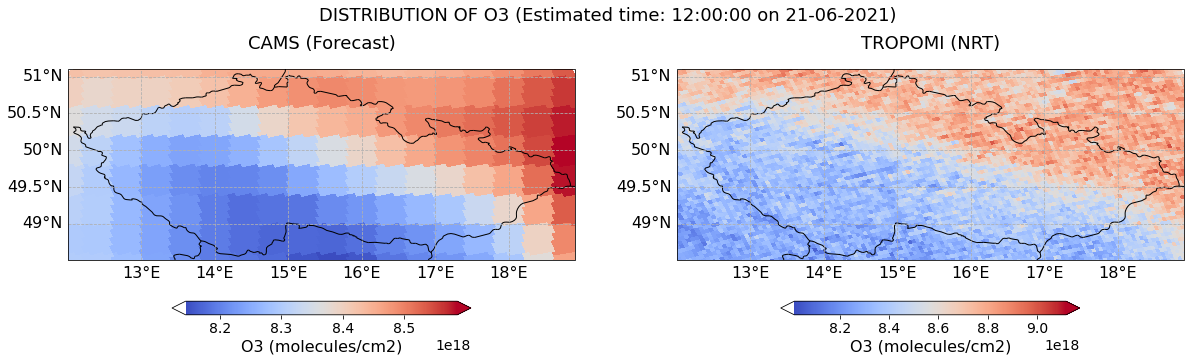

In [25]:
units = component_nom + ' (molecules/cm2)'
projection = ccrs.PlateCarree()

for step in match_df['step_index'].unique():
    
    fig, axs = plt.subplots(1, 2, figsize = (20, 5), subplot_kw = {'projection': projection})

    t = model_ds.isel(step = step).time

    # First plot - CAMS 
    array = model_final_ds.sel(time = t)
    if np.nanmin(array) < 0:
        vmin = 0
    else:
        vmin = np.nanmin(array)
    long_name = model.upper() + ' (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[0],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = vmin, 
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    # Second plot - TROPOMI
    array = sensor_final_ds.sel(time = t)
    if np.nanmin(array) < 0:
        vmin = 0
    else:
        vmin = np.nanmin(array)
    long_name = sensor.upper() + ' (NRT)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[1],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = vmin,  
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} (Estimated time: 12:00:00 on 21-06-2021)',
                  fontsize = 18)
    plt.show()

## 7. Compare CAMS original and averaged total columns

In [26]:
CAMS_tc_download(start_date, end_date, component, component_nom)
model_total_ds = CAMS_tc_read(start_date, end_date, component, component_nom)
model_total_ds = CAMS_subset(model_total_ds, bbox)
if component_nom == 'O3':
    component_nom_total = 'gtc' + component_nom.lower()
else:
    component_nom_total = 'tc' + component_nom.lower()

The file exists, it will not be downloaded again.


In [27]:
# From kg/m2 to molecules/cm2
model_total_ds = CAMS_kg_m2_to_molecules_cm2(model_total_ds, component_mol_weight)
model_total_ds

<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 4)
Coordinates:
    number      int64 ...
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (step) datetime64[ns] ...
Data variables:
    gtco3       (step, latitude, longitude) float32 8.195e+18 ... 8.612e+18
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-08-13T18:49 GRIB to CDM+CF via cfgrib-0.9.9...

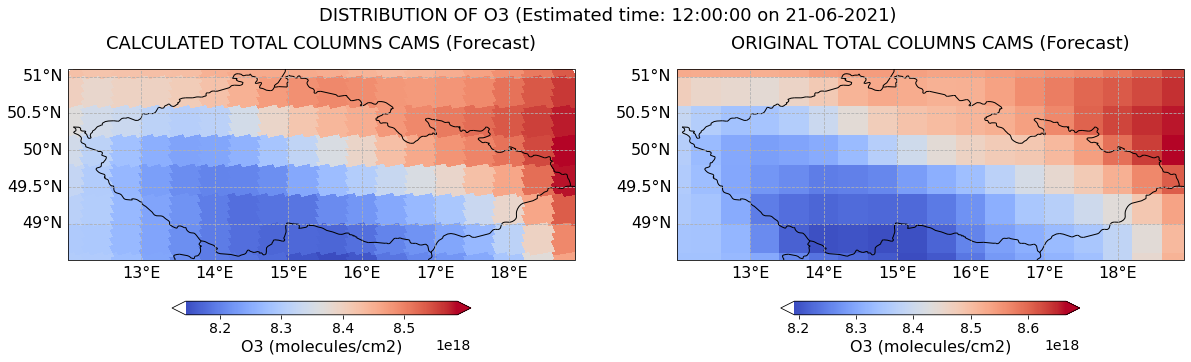

In [28]:
units = component_nom + ' (molecules/cm2)'
projection = ccrs.PlateCarree()

for step in match_df['step_index'].unique():

    fig, axs = plt.subplots(1, 2, figsize = (20, 5), subplot_kw = {'projection': projection})

    t = model_ds.isel(step = step).time

    # First plot - CAMS
    array = model_final_ds.sel(time = t)
    if np.nanmin(array) < 0:
        vmin = 0
    else:
        vmin = np.nanmin(array)
    long_name = 'CALCULATED TOTAL COLUMNS ' + model.upper() + ' (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[0],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = vmin, 
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    # Second plot - TROPOMI
    array = model_total_ds[component_nom_total].isel(step = step)
    if np.nanmin(array) < 0:
        vmin = 0
    else:
        vmin = np.nanmin(array)
    long_name = 'ORIGINAL TOTAL COLUMNS ' + model.upper() + ' (Forecast)'
    visualize_pcolormesh(
                        fig = fig, axs = axs[1],
                        data_array = array.fillna(-999),
                        longitude = array.longitude,
                        latitude = array.latitude,
                        projection = ccrs.PlateCarree(),
                        color_scale = 'coolwarm',
                        long_name = long_name,
                        units = units,
                        vmin = vmin,
                        vmax = np.nanmax(array), 
                        set_global = False,
                        lonmin = bbox[0][0],
                        lonmax = bbox[1][0],
                        latmin = bbox[0][1],
                        latmax = bbox[1][1]
                        )

    fig.suptitle(f'DISTRIBUTION OF {component_nom} (Estimated time: 12:00:00 on 21-06-2021)',
                  fontsize = 18)
    plt.show()


## References
### Data sources
* CAMS global atmospheric composition forecasts (https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)
* TROPOMI (https://s5phub.copernicus.eu/dhus)

### Important documentation
* TROPOMI user manual (https://sentinels.copernicus.eu/documents/247904/3119978/Sentinel-5P-Level-2-Input-Output-Data-Definition)
* TROPOMI NO2 product manual (http://www.tropomi.eu/sites/default/files/files/S5P-KNMI-L2-0021-MA-Product_User_Manual_for_the_Sentinel_5_precursor_Nitrogen_dioxide-0.8.1_20151207_signed.pdf)
* TROPOMI CO product manual (http://www.tropomi.eu/sites/default/files/files/Sentinel-5P-Level-2-Product-User-Manual-Carbon-Monoxide_v1.00.02_20180613.pdf)
* SENTINEL API documentation (https://readthedocs.org/projects/sentinelsat/downloads/pdf/stable/)
* Xarray API reference (http://xarray.pydata.org/en/stable/api.html)

### External functions
* Interpolation (http://christopherbull.com.au/python/scipy-interpolate-griddata/)
* Visualization function (https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb)
* Mask NaN values (https://matplotlib.org/2.0.2/examples/pylab_examples/image_masked.html)
* Convert units (https://confluence.ecmwf.int/pages/viewpage.action?pageId=153391710)
* Install eccodes (https://gist.github.com/MHBalsmeier/a01ad4e07ecf467c90fad2ac7719844a)